In [1]:
pip install dask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Dataset

__MNIST dataset__:
- collection of 70 000 grayscale images of the 10 digits
- each image is 28x28 pixels large, taking values from 0 to 255
- dataset located at: `https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz`



In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#check the sizes of the loaded datasets
datasets = ['x_train', 'y_train', 'x_test', 'y_test']
shape = lambda array: array.shape
dict(zip(datasets, list(map(shape, map(eval, datasets)))))

{'x_train': (60000, 28, 28),
 'y_train': (60000,),
 'x_test': (10000, 28, 28),
 'y_test': (10000,)}

In [3]:

shape(x_train)

(60000, 28, 28)

In [4]:
# map stores the object with the logical map at some location in the memory, but does not load the result of the operaration into the memory 
print(map(shape, map(eval, datasets)))

In [15]:
# prints the content of the memory 
print(*map(shape, map(eval, datasets)))

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

5 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241
   0   0   0   0   0   0   0   0   0   0]


<AxesSubplot:>

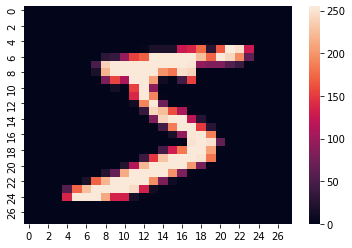

In [7]:
idx_ = 8
#10-th row of the first image 

print(y_train[0], x_train[0][idx_])
sns.heatmap(x_train[0])

# Pandas and Dask Benchmarking 

In [40]:
import pandas as pd
import dask.dataframe as dd

## 1. Store MNIST train dataset into csv file


In [28]:
%%time
df_train = pd.DataFrame(data=list(zip(y_train, x_train)), columns=['label', 'image'])
df_test = pd.DataFrame(data=list(zip(y_test, x_test)), columns=['label', 'image'])

CPU times: user 46.9 ms, sys: 5.04 ms, total: 52 ms
Wall time: 51.4 ms


In [26]:
%%time
df_train.to_csv('mnist_train.csv', index=False)

CPU times: user 1min 28s, sys: 1.09 s, total: 1min 29s
Wall time: 1min 29s


In [27]:
%%time
df_train.to_csv('mnist_train.csv.gzip', compression='gzip', index=False)

CPU times: user 1min 47s, sys: 158 ms, total: 1min 48s
Wall time: 1min 47s


## Exercise 1: 
1. store MNIST test dataset into the csv file
2.  store MNIST test dataset into the compressed csv file 

## 2. Experiment 1: Loading data into DataFrame 

In [20]:
%%bash 
ls -lha

total 203M
drwxr-xr-x 1 root root 4.0K Mar 12 16:06 .
drwxr-xr-x 1 root root 4.0K Mar 12 15:36 ..
drwxr-xr-x 4 root root 4.0K Mar  9 18:57 .config
-rw-r--r-- 1 root root 188M Mar 12 16:11 mnist_train.csv
-rw-r--r-- 1 root root  15M Mar 12 16:13 mnist_train.csv.gzip
drwxr-xr-x 1 root root 4.0K Mar  9 18:58 sample_data


### 2.1 Compresed Files 

In [68]:
%%timeit
df_pandas_train_compressed = pd.read_csv('mnist_train.csv.gzip', compression='gzip')

2.28 s ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
%%timeit
df_dask_train_compressed = dd.read_csv('mnist_train.csv.gzip', compression='gzip', blocksize=None)

6.93 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 2.2 Original Files 

In [66]:
%%timeit
df_pandas_train = pd.read_csv('mnist_train.csv')

1.73 s ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
%%timeit
df_dask_train = dd.read_csv('mnist_train.csv', blocksize=None)

5.1 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 3. Experiment 2: Basic Operations on the DataFrames 

In [46]:
df_pandas_train

,label,image
0,5,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
1,0,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
2,4,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
3,1,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
4,9,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...
59995,8,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
59996,3,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
59997,5,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
59998,6,[[ 0 0 0 0 0 0 0 0 0 0 0 ...


In [70]:
df_dask_train

,label,image
npartitions=1,,
,int64,object
,...,...


### 3.1 Size of the Dataset 

In [62]:
%%timeit
len(df_pandas_train)

445 ns ± 8.13 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [63]:
%%timeit
len(df_dask_train)

985 ms ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 3.2 Groupby Operations 

In [65]:
%%timeit
df_pandas_train.groupby('label').size()

1.17 ms ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [64]:
%%timeit
df_dask_train.groupby('label').size()

2.79 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [86]:
res = df_dask_train.groupby('label').size()

In [87]:
res.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7fe7868bc880>
 0. read-csv-bc73aa6ed16752215132b5c35f803515
 1. dataframe-groupby-size-chunk-36e79f62906815c192d9d2d09583d950-785e675a4bfbf0a7ae28d3ab91a76e58
 2. dataframe-groupby-size-agg-36e79f62906815c192d9d2d09583d950

In [104]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [97]:
from concurrent.futures import ThreadPoolExecutor
import dask

In [101]:
%%timeit 
with dask.config.set(pool=ThreadPoolExecutor(4)):
  df_dask_train.groupby('label').size()

2.71 ms ± 52.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [105]:
%%timeit 
with dask.config.set(pool=ThreadPoolExecutor(6)):
  df_dask_train.groupby('label').size()

2.69 ms ± 87.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [106]:
%%timeit 
with dask.config.set(pool=ThreadPoolExecutor(8)):
  df_dask_train.groupby('label').size()

2.69 ms ± 30.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [107]:
%%timeit 
with dask.config.set(pool=ThreadPoolExecutor(12)):
  df_dask_train.groupby('label').size()

2.7 ms ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [108]:
%%timeit 
with dask.config.set(num_workers=4):
      df_dask_train.groupby('label').size()

2.77 ms ± 50.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [109]:
%%timeit 
with dask.config.set(num_workers=6):
      df_dask_train.groupby('label').size()

2.78 ms ± 94.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [110]:
%%timeit 
with dask.config.set(num_workers=8):
      df_dask_train.groupby('label').size()

2.69 ms ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [111]:
%%timeit 
with dask.config.set(num_workers=12):
      df_dask_train.groupby('label').size()

2.7 ms ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Dask DataFrame to and from Pandas DataFrame, 

In [112]:
type(df_dask_train)

dask.dataframe.core.DataFrame

In [114]:
%%timeit
df_dask2pandas_train = pd.DataFrame(df_dask_train)

1.95 s ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [115]:
%%timeit
df_dask2pandas_train = df_dask_train.compute()

1.94 s ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [113]:
type(df_dask2pandas_train)

pandas.core.frame.DataFrame

In [116]:
type(df_pandas_train)

pandas.core.frame.DataFrame

In [122]:
df_pandas_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   60000 non-null  int64 
 1   image   60000 non-null  object
dtypes: int64(1), object(1)
memory usage: 937.6+ KB


In [127]:
df_pandas_train.memory_usage()

Index       128
label    480000
image    480000
dtype: int64

In [132]:
# getting the size of the dataframe 
df_pandas_train.memory_usage().sum() 

960128

In [133]:
# getting the size of the dataframe: iteratively computes the size of the objects within the columns
df_pandas_train.memory_usage(deep=True)

Index          128
label       480000
image    199980000
dtype: int64

In [135]:
import sys 
sys.getsizeof(df_pandas_train), df_pandas_train.memory_usage(deep=True).sum()

(200460144, 200460128)

In [118]:
df_dask_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 2 entries, label to image
dtypes: object(1), int64(1)

In [142]:
%%timeit
df_pandas2dask_train = dd.from_pandas(df_pandas_train, npartitions=3)

528 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
df_pandas2dask_train = dd.from_pandas(df_pandas_train, npartitions=3)
df_pandas2dask_train

,label,image
npartitions=3,,
0,int64,object
20000,...,...
40000,...,...
59999,...,...


In [145]:
%%timeit 
with dask.config.set(pool=ThreadPoolExecutor(8)):
  df_pandas2dask_train.groupby('label').size()

2.74 ms ± 85.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [146]:
res = df_pandas2dask_train.groupby('label').size()

In [147]:
res.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7fe7b9c57a90>
 0. from_pandas-2aea99da16d8743dc8d9422ab98ad370
 1. dataframe-groupby-size-chunk-a931cd6fe778703115f610d3d1ca44ba-b46976794f0b8a7205eca7e57ac614d4
 2. dataframe-groupby-size-agg-a931cd6fe778703115f610d3d1ca44ba

## 4. Experiment 3: Merging DataFrames 

In [56]:
df_dask_train.head(5)

,label,image
0,5,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
1,0,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
2,4,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
3,1,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
4,9,[[ 0 0 0 0 0 0 0 0 0 0 0 ...


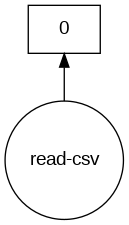

In [181]:
dask.visualize(df_dask_train)

In [57]:
df_pandas_train.head(5)

,label,image
0,5,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
1,0,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
2,4,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
3,1,[[ 0 0 0 0 0 0 0 0 0 0 0 ...
4,9,[[ 0 0 0 0 0 0 0 0 0 0 0 ...


In [83]:
sample_size = 100

temp_pandas_1 = df_pandas_train.head(sample_size)
temp_dask_1 = df_dask_train.head(sample_size)

temp_pandas_2 = df_pandas_train.tail(sample_size)
temp_dask_2 = df_dask_train.tail(sample_size)

In [84]:
%%timeit
pd.merge(temp_pandas_1, temp_pandas_2)

1.82 ms ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [176]:
%%timeit
dd.merge(temp_dask_1, temp_dask_2)

1.82 ms ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [185]:
import timeit
import numpy as np

timeit.timeit(lambda: dd.merge(temp_dask_1, temp_dask_2), number=100)

0.17958605400053784

In [186]:
times_res = timeit.repeat(lambda: dd.merge(temp_dask_1, temp_dask_2), repeat=7, number=1000)

In [168]:
dict(zip(['values', 'mean', 'std'], [np.array(times_res), np.array(times_res).mean(), np.array(times_res).std()*1000]))

{'values': array([1.93993888, 1.91725548, 1.92653867, 1.90456389, 1.90934935,
        1.93301223, 1.94945485]),
 'mean': 1.925730477000148,
 'std': 15.149696316878607}

## Exercise 2:
Explore the performance of mergin files in dask and pandas.
1. Choose the grid for the size of the dataset 
2. Compute the time performance of the merge function for varying dataset sizes in dask
3. Compute the time performance of the merge function for varying dataset sizes in pandas
4. Visualise the results 
